In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
n = 50

n_rad = int( n/2 )
n_ang = int( n*np.pi )

#num_blocks = ( n_rad - 1 ) * n_ang + 1 # for sampling isolated points
num_blocks = n_ang # for choosing radia
#num_blocks = n_rad # for choosing circles
nb_samples = int( num_blocks * 2 / np.pi )

phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Rad, Phi = np.meshgrid( rad, phi )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-4,"gamma":1e-10}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 1
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat) + 
               0.1*np.mean(u0_mat)*np.random.randn(2*(n_rad-1)*n_ang+2).view(np.complex128) 
               for u0_mat in images]

In [7]:
param["c"] = 1e-8
param["beta"] = 1e-6

In [8]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , const={"sigma":0.5,"tau":1} , n_rad = n_rad)

## Learning points

In [9]:
p0 = np.random.rand(n_ang*(n_rad-1)+2)
p0[-1] = 1e-3

print("Penalty:",P(p0,param["beta"]))
print("Total energy:",E(pk = p0 , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 0.0003709989301075727


/home/guillaume/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Total energy: 9.898071941401243


In [10]:
pf,energy_upper,alphas = obj.optimize(p0=p0 , mask_type = "radial")


1 iterations: E(p)=8.970181442948753, alpha=0.13161891302569312



2 iterations: E(p)=8.48401010870127, alpha=0.5545278264259333



3 iterations: E(p)=8.458593138139296, alpha=0.7377199061020443



4 iterations: E(p)=8.327793896098644, alpha=0.9681152982625874



5 iterations: E(p)=8.215308409504578, alpha=1.3060675592418338



6 iterations: E(p)=8.137414390320487, alpha=1.7761539526241616



7 iterations: E(p)=8.098797290680096, alpha=2.2769776403805104



8 iterations: E(p)=8.008098242766765, alpha=2.492213958511924



9 iterations: E(p)=7.854271487147303, alpha=2.783174136255182



10 iterations: E(p)=7.840730531113571, alpha=3.015446402384238



FINISHED IN 108.69390535354614 SECONDS



9.898071941401243 7.840730531113571


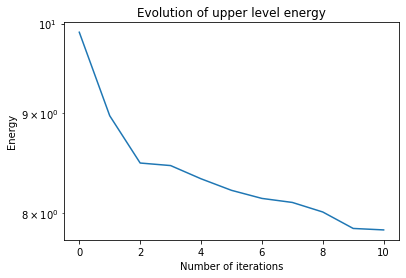

In [11]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

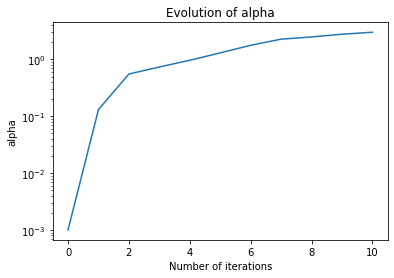

In [12]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [13]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(pf,param["beta"]))
print("Total energy:",E(pk = pf , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 0.0005589999999999999
Total energy: 11.358643683014721


In [14]:
# -- Compute mean ssim of final mask and its ceiled version --
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.952832631370482
Mean ssim ceiled mask:0.9473962781722147


In [15]:
ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
pysap.Image(data = convert_locations_to_mask(np.array(ceiled_mask),(n,n))).show()

# Radial Center-Out mask

In [9]:
from UpperLevel.parametrisation import *
l0 = np.random.rand(n_ang+2)
l0[-1] = 1e-3
p0 = pradCO(l0,n_rad)

m = []
for i in range(len(p0)-1):
    if p0[i]>0.5:m.append(full_kspace_loc[i])
#pysap.Image(data = convert_locations_to_mask(np.array(m),(n,n))).show()

In [10]:
lf,energy_upper,alphas = obj.optimize(l0=l0 , mask_type = "radial_CO")

/home/guillaume/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



1 iterations: E(p)=11.399368355115183, alpha=0.09442504746183067



2 iterations: E(p)=11.073430293724876, alpha=0.15259448999751543



3 iterations: E(p)=11.012394359122226, alpha=0.28549754649965886



FINISHED IN 43.577693939208984 SECONDS



39.671696224876236 11.012394359122226


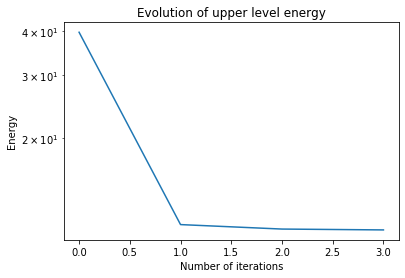

In [11]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

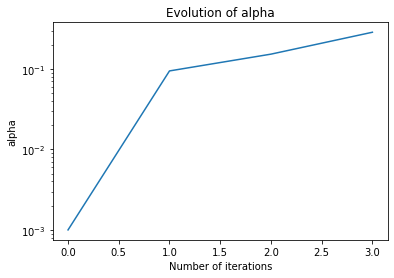

In [12]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [14]:
print(lf[-1])
pf = pradCO(lf,n_rad)
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
pysap.Image(data = convert_locations_to_mask(np.array(ceiled_mask),(n,n))).show()

0.28549754649965886


In [15]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(pf,param["beta"]))
print("Total energy:",E(pk = pf , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 0.0003083095436146781
Total energy: 11.01266682431097


In [16]:
# -- Compute mean ssim of final mask and its ceiled version --
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9290931975790453
Mean ssim ceiled mask:0.8316141011894114
